In [1]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline

/Users/akarsh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.set_printoptions(precision=2)

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.14.0'

---

Load MNIST Data

---

In [5]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

A generic layer class with forward and backward methods

----

In [6]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

CCE loss and its gradient

---

In [7]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 0)))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

---

Generic activation layer class

---

In [8]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient * self.activation_gradient(self.input))

---

Specific activation layer classes

---

In [10]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            a = np.tanh(z)
            return 1 - a**2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

---

Softmax activation layer class

---

In [11]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.output = tf.nn.softmax(input, axis = 0).numpy()

  def backward(self, output_gradient, learning_rate = None):
    ## Following is the inefficient way of calculating the backward gradient
    softmax_gradient = np.empty((self.output.shape[0], output_gradient.shape[1]), dtype = np.float64)
    #for b in range(softmax_gradient.shape[1]):
    #  softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-np.atleast_2d(self.output[:, b])) * np.atleast_2d(self.output[:, b]).T, output_gradient[:, b])
    #return(softmax_gradient)
    ## Following is the efficient of calculating the backward gradient
    T = np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (2, 1, 0)) * np.atleast_2d(self.output)
    return(np.einsum('jik, ik -> jk', T, output_gradient))

---

Dense layer class

---

In [12]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        #weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        #for b in range(output_gradient.shape[1]):
        #  weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        #weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        ## Following is the efficient way of calculating the weights gradient w.r.t. data
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])


        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

In [13]:
class Dropout(Layer):

  def __init__(self, dropout_probability = 0.02):
    self.dropout_probability = dropout_probability
    self.D = None

  def forward(self, input):
    self.D = (np.random.rand(input.shape[0],input.shape[1]))
    self.D = (self.D < (1 - self.dropout_probability))
    self.output = (input * self.D) / (1- self.dropout_probability)
    self.output

  def backward(self, output_gradient):
    return(self.D * output_gradient[:-1,:])

---

Function to generate sample indices for batch processing according to batch size

---

In [14]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Train the 1-hidden layer neural network (128 nodes) using batch training with batch size = 100

---

In [15]:
## Train the 2-hidden layer neural network (128 nodes)
## using batch training with batch size = 100
learning_rate = 1# learning rate
batch_size = 100 # batch size
nepochs = 100 # number of epochs
reg_strength = 0.01 # regularization strength
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)


# Neural network architecture

dlayer1 = Dense(num_features, 128, reg_strength) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dropout1 = Dropout(0.5)
dlayer2 = Dense(128, num_labels, reg_strength) # define dense layer 2
softmax = Softmax() # define softmax activation layer

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    # Forward propagation for training data
    dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dropout1.forward(alayer1.output)
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate
    # Calculate training data loss
    loss += cce(Y_train[:, batch_indices[b]], softmax.output)
    # Add the regularization losses
    loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer2.backward(grad, learning_rate)
    grad = dropout1.backward(grad)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)
  softmax.forward(dlayer2.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  cce(Y_test, softmax.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1
  

  


Epoch 1: train loss = 1.072623, test loss = 1.037247
Epoch 2: train loss = 0.989276, test loss = 1.007154
Epoch 3: train loss = 0.979016, test loss = 0.993391
Epoch 4: train loss = 0.983459, test loss = 1.213874
Epoch 5: train loss = 0.997759, test loss = 0.877429
Epoch 6: train loss = 0.987077, test loss = 0.852247
Epoch 7: train loss = 1.000806, test loss = 1.152306
Epoch 8: train loss = 0.983074, test loss = 1.510620
Epoch 9: train loss = 0.994391, test loss = 1.105392
Epoch 10: train loss = 0.982107, test loss = 1.043629
Epoch 11: train loss = 1.003009, test loss = 1.116675
Epoch 12: train loss = 1.014147, test loss = 0.922297
Epoch 13: train loss = 1.000980, test loss = 0.889223
Epoch 14: train loss = 1.012269, test loss = 0.907195
Epoch 15: train loss = 0.995364, test loss = 0.942001
Epoch 16: train loss = 1.010114, test loss = 1.095660
Epoch 17: train loss = 1.011815, test loss = 1.344473
Epoch 18: train loss = 1.011591, test loss = 1.081012
Epoch 19: train loss = 1.000531, test

---

Plot training loss vs. epoch

---

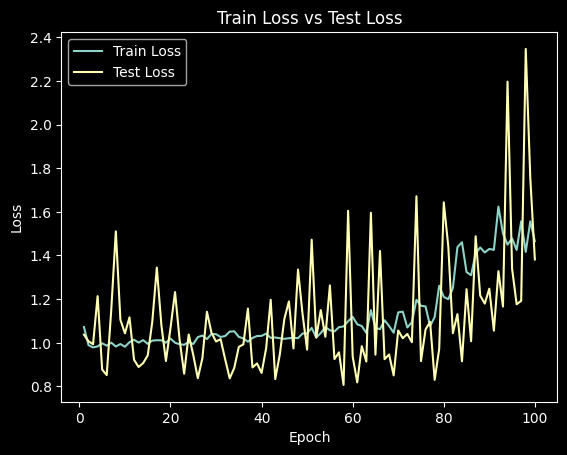

In [18]:
# Plot train loss vs test loss curve
import matplotlib.pyplot as plt
plt.plot(range(1, nepochs+1), loss_train_epoch, label='Train Loss')
plt.plot(range(1, nepochs+1), loss_test_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

---

Test performance on test data

---

In [19]:
dlayer1.forward(X_test)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
softmax.forward(dlayer2.output)
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)

[7 2 1 ... 4 8 6]
[7 2 1 ... 4 5 6]


0.6002